In [1]:
import pandas as pd
from tqdm import tqdm
import gc
import numpy as np
import torch

In [ ]:
features_df = pd.read_csv("../hackathon_symlink/ВК/FINAL_FEATURES_TRAINTEST.tsv", sep="\t")

feature_subset = []

u0_prefix = ["u0=" + str(x) for x in [10, 11, 12, 15, 16, 17, 20, 21, 22]]
for pref in u0_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 6) for col in features_df.columns]])
    
u1_prefix = ["u1=" + str(x) for x in [11, 13, 15, 16, 17, 18, 19, 20, 23, 24, 27, 28, 30, 32, 37]]
for pref in u1_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 6) for col in features_df.columns]])
    
u2_prefix = ["u2=" + str(x) for x in [10, 11]]
for pref in u2_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 6) for col in features_df.columns]])
    
u2_prefix_short = ["u2=" + str(x) for x in [1, 2, 3, 4, 5, 6, 7, 8, 9]]
for pref in u2_prefix_short:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 5) for col in features_df.columns]])
    
u_prefixes = ["u" + str(x) for x in [0, 1, 2, 3, 4, 5, 6, 7, 8]]
for pref in u_prefixes:
    feature_subset.append(features_df.columns[[pref in col for col in features_df.columns]])
    
i_prefix = ["i" + str(x) for x in [10, 11, 12, 13, 14, 15, 16, 17, 25, 27, 29, 31, 32, 33, 34, 35, 36, 42, 43, 44, 45]]
for pref in i_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 5) for col in features_df.columns]])
    
i_short_prefix = ["i" + str(x) for x in [1, 2, 3, 4]]
for pref in i_short_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 5) for col in features_df.columns]])

i_len_4_prefix = ["i" + str(x) for x in [4, 5, 6, 7, 8, 9]]
for pref in i_len_4_prefix:
    feature_subset.append(features_df.columns[[(pref in col and len(col) == 4) for col in features_df.columns]])
    
features_df.to_parquet("../hackathon_symlink/features_with_spammed_features.parquet", index=False)    

In [29]:
targets_df = pd.read_csv("../hackathon_symlink/ВК/FINAL_TARGETS_DATES_TRAINTEST.tsv", sep="\t")
seq_df = pd.read_csv("../hackathon_symlink/ВК/FINAL_ALL_SEQUENCES_TRAINTEST.tsv", sep="\t")

In [30]:
seq_df["SEQUENCE"] = seq_df["SEQUENCE"].apply(eval)

In [59]:
seq_df["seq_len"] = seq_df["SEQUENCE"].apply(len)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = seq_df["SEQUENCE"].apply(" ".join)
vectorizer = TfidfVectorizer(min_df=5, max_df=0.98)

tfidf_df = vectorizer.fit_transform(corpus)

In [61]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=512, n_iter=7, random_state=42)
svd_df = svd.fit_transform(tfidf_df)

In [63]:
seq_df = pd.concat([seq_df[["CLIENT_ID", "seq_len"]], pd.DataFrame(svd_df).rename(columns={i: str(i) + "_svd" for i in range(svd_df.shape[1])})], axis=1)

In [94]:
df = targets_df.merge(seq_df, on="CLIENT_ID", how="left")
df["empty_seq"] = df["seq_len"].isna().astype(int)
df = df.fillna(0)

dttm = pd.to_datetime(df["RETRO_DT"], format="%Y%m%d")

df["month"] = dttm.dt.month
df["week"] = dttm.dt.isocalendar().week
df["dayofweek"] = dttm.dt.dayofweek
df["day"] = dttm.dt.day

features_df = pd.read_parquet("../hackathon_symlink/features_with_spammed_features.parquet")
df = df.merge(features_df, how="left", on="CLIENT_ID")
test_df = df[df["TARGET"] == "test"]
train_df = df[df["TARGET"] != "test"]

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

RANDOM_STATE = 42
N_THREADS = 50
TIMEOUT = 600
N_FOLDS = 5


Xy_train, Xy_test = train_test_split(train_df, random_state=1337)

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('binary')
roles = {"target": "TARGET", "drop": ["CLIENT_ID", "RETRO_DT"]}

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
oof_pred = automl.fit_predict(Xy_train, roles=roles, verbose=1).data[:, 0]
test_pred = automl.predict(Xy_test).data[:, 0]

train_auc = roc_auc_score(Xy_train['TARGET'], oof_pred)
print(f"OOF SCORE: {train_auc}")

test_auc = roc_auc_score(Xy_test['TARGET'], test_pred)
print(f"TEST SCORE: {test_auc}")

(0.0, 50.0)

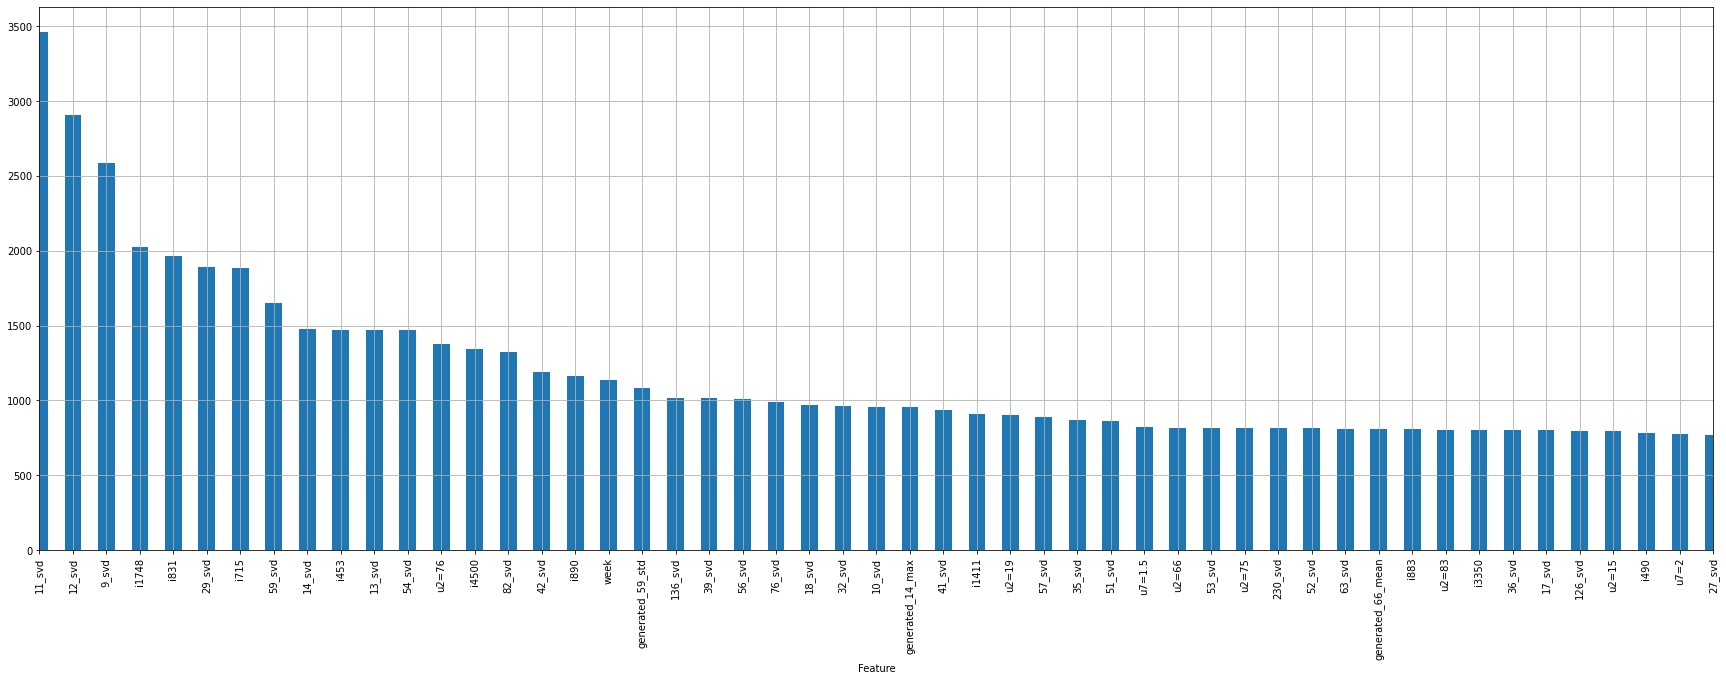

In [179]:
automl_rd = automl

fast_fi = automl_rd.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
plt.xlim([0, 50])

In [236]:
best_features = list(df.columns[[col in set(fast_fi[fast_fi["Importance"] > 250].Feature) for col in df.columns]])

div2_features = [feat for feat in best_features if ("svd" not in feat) and ("generated" not in feat) and (("i" in feat))]

for feat in div2_features:
    df[feat + "_even"] = df[feat].fillna(0).apply(lambda x: int(x) % 2 == 0).astype(int)

In [9]:
### friend feature generation

import pandas as pd
import gc
from tqdm import tqdm
from lightgbm import LGBMClassifier
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score
import pickle as pkl


targets = pd.read_csv('..hackathon_symlink/ВК/FINAL_TARGETS_DATES_TRAINTEST.tsv', sep='\t')
feats = pd.read_parquet('..hackathon_symlink/features_with_spammed_features.parquet')

feats = feats.merge(targets, on='CLIENT_ID', how='left')

friends = pd.read_csv('..hackathon_symlink/ВК/FINAL_FEATURES_FRIENDS.tsv', sep='\t')

model = LGBMClassifier(importance_type='gain', n_jobs=20, silent=False)
model.fit(feats.drop(columns=['TARGET', 'CLIENT_ID', 'RETRO_DT']), feats['TARGET'], verbose=2)

top_features = list(pd.Series(model.feature_name_)[np.argsort(model.feature_importances_)])[-100:]
top_features_generated = [f for f in top_features if 'generated' in f]
top_features_ngenerated = [f for f in top_features if 'generated' not in f]
friends_top = friends.loc[:, ['CLIENT_ID', 'FRIEND_ID'] + top_features_ngenerated]

friends_grouped = friends_top.groupby('CLIENT_ID', as_index=False).agg({**{f: ['mean', 'min', 'max'] for f in top_features_ngenerated},
                                                                        'FRIEND_ID': ['count']})

friends_grouped.to_csv('..hackathon_symlink/FRIEND_GROUPED.tsv', sep='\t', index=False)

In [244]:
friends_features = pd.read_csv("../hackathon_symlink/FRIEND_GROUPED.tsv", sep="\t", skiprows=1)
friends_features = friends_features.rename(columns={col: "friend_" +col for col in friends_features.columns}).rename(columns={"friend_Unnamed: 0": "CLIENT_ID"})

In [243]:
df.to_parquet("../hackathon_symlink/sashik_2k_features_without_friends.parquet", index=False)

In [246]:
df = df.merge(friends_features, how="left", on="CLIENT_ID")
df["no_friends_:("] = df["friend_count"].isna().astype(int)

In [280]:
from sklearn.decomposition import TruncatedSVD


svd_for_vis = TruncatedSVD(n_components=64, n_iter=7, random_state=42)
svd_df = svd_for_vis.fit_transform(df.drop(["CLIENT_ID", "RETRO_DT", "TARGET"], axis=1).fillna(0))

In [283]:
svd_df = pd.concat([df[["CLIENT_ID", "TARGET"]], pd.DataFrame(svd_df).rename(columns={i: str(i) + "_svd_for_cluster" for i in range(svd_df.shape[1])})], axis=1)

In [310]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors()
X_train = svd_df[svd_df["TARGET"] != "test"]
X_test = svd_df[svd_df["TARGET"] == "test"]
X = X_train.drop(["CLIENT_ID", "TARGET"], axis=1)
neigh.fit(X)

NearestNeighbors()

In [323]:
X = X_train.drop(["CLIENT_ID", "TARGET"], axis=1)
dists, idxs = neigh.kneighbors(X)
near_targets = X_train["TARGET"].to_numpy()[idxs[:, 1:]]
near_targets_df = pd.DataFrame(near_targets).rename(columns={i: f"near_target_{i}" for i in range(near_targets.shape[1])})
near_dists_df = pd.DataFrame(dists[:, 1:]).rename(columns={i: f"near_dist_{i}" for i in range(dists.shape[1])})

In [324]:
train_friends_df = pd.concat([
    X_train[["CLIENT_ID"]].reset_index(drop=True), 
    near_targets_df.reset_index(drop=True), 
    near_dists_df.reset_index(drop=True)
], axis=1)

In [325]:
X = X_test.drop(["CLIENT_ID", "TARGET"], axis=1)
dists, idxs = neigh.kneighbors(X)
near_targets = X_train["TARGET"].to_numpy()[idxs[:, 1:]]
near_targets_df = pd.DataFrame(near_targets).rename(columns={i: f"near_target_{i}" for i in range(near_targets.shape[1])})
near_dists_df = pd.DataFrame(dists[:, 1:]).rename(columns={i: f"near_dist_{i}" for i in range(dists.shape[1])})

In [326]:
test_friends_df = pd.concat([
    X_test[["CLIENT_ID"]].reset_index(drop=True), 
    near_targets_df.reset_index(drop=True), 
    near_dists_df.reset_index(drop=True)
], axis=1)

In [328]:
friends_targets_df = pd.concat([train_friends_df, test_friends_df])

In [333]:
friends_targets_df["min_dist"] = friends_targets_df[["near_dist_0", "near_dist_1", "near_dist_2", "near_dist_3"]].agg(min, axis=1)
friends_targets_df["max_dist"] = friends_targets_df[["near_dist_0", "near_dist_1", "near_dist_2", "near_dist_3"]].agg(max, axis=1)
friends_targets_df["mean_dist"] = friends_targets_df[["near_dist_0", "near_dist_1", "near_dist_2", "near_dist_3"]].agg("mean", axis=1)

friends_targets_df[["near_target_0", "near_target_1", "near_target_2", "near_target_3"]] = friends_targets_df[["near_target_0", "near_target_1", "near_target_2", "near_target_3"]].astype(int)

friends_targets_df["sum_target"] = friends_targets_df[["near_target_0", "near_target_1", "near_target_2", "near_target_3"]].agg("sum", axis=1)
friends_targets_df["mean_target"] = friends_targets_df[["near_target_0", "near_target_1", "near_target_2", "near_target_3"]].agg("mean", axis=1)

In [343]:
friends_targets_df.to_parquet("../hackathon_symlink/sashik_friends_target_encoded.parquet", index=False)

In [344]:
target_encoded = df[["CLIENT_ID", "TARGET"]]
target_encoded = target_encoded[target_encoded["TARGET"] != "test"]
target_encoded = target_encoded.merge(friends_targets_df, how="left", on="CLIENT_ID")

In [348]:
df = df.merge(friends_targets_df, how="left", on="CLIENT_ID")

In [355]:
lifestream_df_train = pd.read_csv("../hackathon_symlink/data/train_embeds_unsup.csv")
lifestream_df_test = pd.read_csv("../hackathon_symlink/data/test_embeds_unsup.csv")
lifestream_df = pd.concat([lifestream_df_train, lifestream_df_test])

In [359]:
df = df.merge(lifestream_df.drop(["RETRO_DT", "TARGET"], axis=1), how="left", on="CLIENT_ID")

In [363]:
df.to_parquet("../hackathon_symlink/24_09_14:00_curr_sota_features.parquet", index=False)

In [381]:
### SUBMIT

test_df = df[df["TARGET"] == "test"]
train_df = df[df["TARGET"] != "test"]

test_df = targets_df[targets_df["TARGET"] == "test"][["CLIENT_ID"]].merge(test_df, how="left", on="CLIENT_ID")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

RANDOM_STATE = 42
N_THREADS = 60
TIMEOUT = 60 * 45
MEM_LIMIT = 128
N_FOLDS = 5


Xy_train = train_df

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('binary')
roles = {"target": "TARGET", "drop": ["CLIENT_ID", "RETRO_DT"]}

automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    memory_limit=MEM_LIMIT,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)
oof_pred = automl.fit_predict(Xy_train, roles=roles, verbose=1).data[:, 0]

train_auc = roc_auc_score(Xy_train['TARGET'], oof_pred)
print(f"OOF SCORE: {train_auc}")

[15:15:10] Stdout logging level is INFO.
[15:15:10] Task: binary

[15:15:10] Start automl preset with listed constraints:
[15:15:10] - time: 2700.00 seconds
[15:15:10] - CPU: 60 cores
[15:15:10] - memory: 128 GB

[15:15:10] Train data shape: (127432, 2683)

[15:19:16] Layer 1 train process start. Time left 2453.86 secs
[15:20:05] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:21:56] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6101737279822481
[15:21:56] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[15:21:56] Time left 2293.79 secs

[15:23:49] Selector_LightGBM fitting and predicting completed
[15:24:08] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[15:28:29] Time limit exceeded after calculating fold 3

[15:28:29] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.632754629262373
[15:28:29] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[15:28:29] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget 

/home/u_m1d6l/.local/lib/python3.7/site-packages/lightautoml/ml_algo/tuning/optuna.py:232: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  name=parameter, **SearchSpace.params
/home/u_m1d6l/.local/lib/python3.7/site-packages/lightautoml/ml_algo/tuning/optuna.py:232: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  name=parameter, **SearchSpace.params


[15:30:03] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[15:30:03] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[15:37:03] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.6279645921727006
[15:37:03] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[15:37:05] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


[15:38:35] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = 0.6399274298957863
[15:38:35] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[15:38:35] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


/home/u_m1d6l/.local/lib/python3.7/site-packages/lightautoml/ml_algo/tuning/optuna.py:232: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  name=parameter, **SearchSpace.params
Default metric period is 5 because AUC is/are not implemented for GPU
/home/u_m1d6l/.local/lib/python3.7/site-packages/lightautoml/ml_algo/tuning/optuna.py:232: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  name=parameter, **SearchSpace.params
Default metric period is 5 because AUC is/are not implemented for GPU
/home/u_m1d6l/.local/lib/python3.7/site-packages/lightautoml/ml_algo/tuning/optuna.py:232: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This fea

[15:43:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[15:43:55] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU


[15:45:37] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.6396506575339352
[15:45:37] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[15:45:37] Time left 873.13 secs

[15:45:37] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[15:45:37] Layer 1 training completed.

[15:45:37] Blending: optimization starts with equal weights and score 0.6415028036435656
[15:45:38] Blending: iteration 0: score = 0.642617423427609, weights = [0.06974829 0.16490078 0.12762366 0.36774185 0.26998547]
[15:45:40] Blending: iteration 1: score = 0.6426745303370487, weights = [0.         0.15443084 0.16305834 0.3812819  0.30122888]
[15:45:41] Blending: iteration 2: score = 0.642674569016046, weights = [0.         0.15889193 0.16228789 0.37922016 0.29959998]
[15:45:43] Blending: iteration 3: score = 0.6426745301823327, weights = [0.         0.15887082 0.16228834 0.37923175 0.29960912]
[15:45:44] Blending: iteration 4: score = 0.642674556329335, weights

(0.0, 50.0)

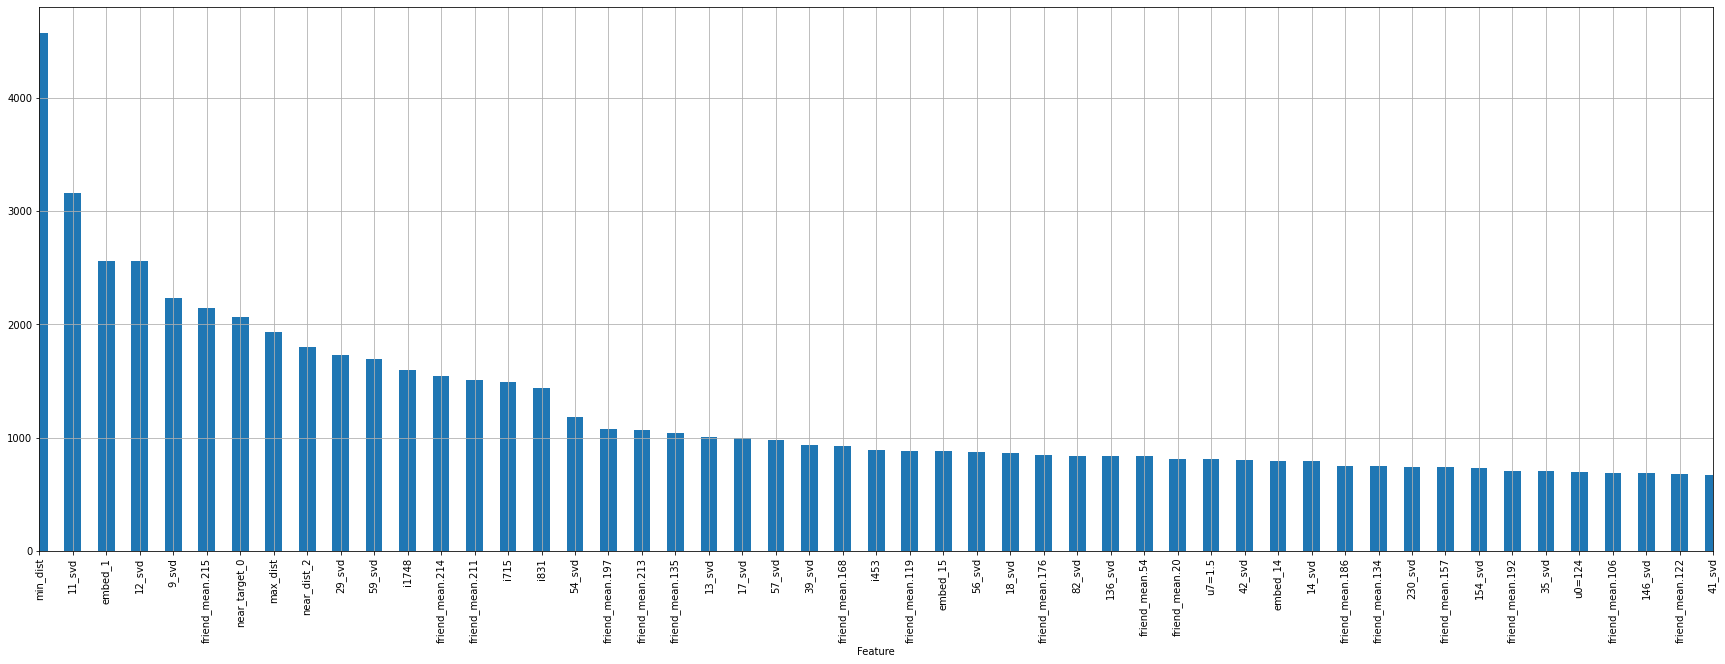

In [388]:
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize=(30, 10), grid=True)
plt.xlim([0, 50])

In [383]:
test_pred = automl.predict(test_df).data[:, 0]

In [384]:
test_pred

array([0.36554036, 0.23569481, 0.2382407 , ..., 0.3271351 , 0.24496362,
       0.20431343], dtype=float32)

In [385]:
submit_df = test_df[["CLIENT_ID"]]
submit_df["TARGET"] = test_pred

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [387]:
submit_df.to_csv("submit_24_09_16_00.csv", index=False)